**Rapport Smart Cities**
====================
**Building Thermal Model**
----------------------
Teacher : Christian Ghiaus

BLANCHARD Lucas, CANAL Gabriel, HOTEIT Raiif, YAP Chloé

**Introduction**
------------

The goal of these tutorials is to present thermodynamic model for a building and more precisely, a model for two rooms. There will be a thermal network modelisation which take into account all the heat transfer from the exterior and the interior. All of this will be implemented in a system of algebric equation then a state-space system. 


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

**Dimensions of the problem**
-------------------------

For the choice of the model, we have decided to choose 2 rooms next to each other with a commun wall. There is a door connecting the rooms and one glasses in each room. For the materials, the walls will be in concrete with a width of 0,1 m and the glass’s width is 0,0,5 

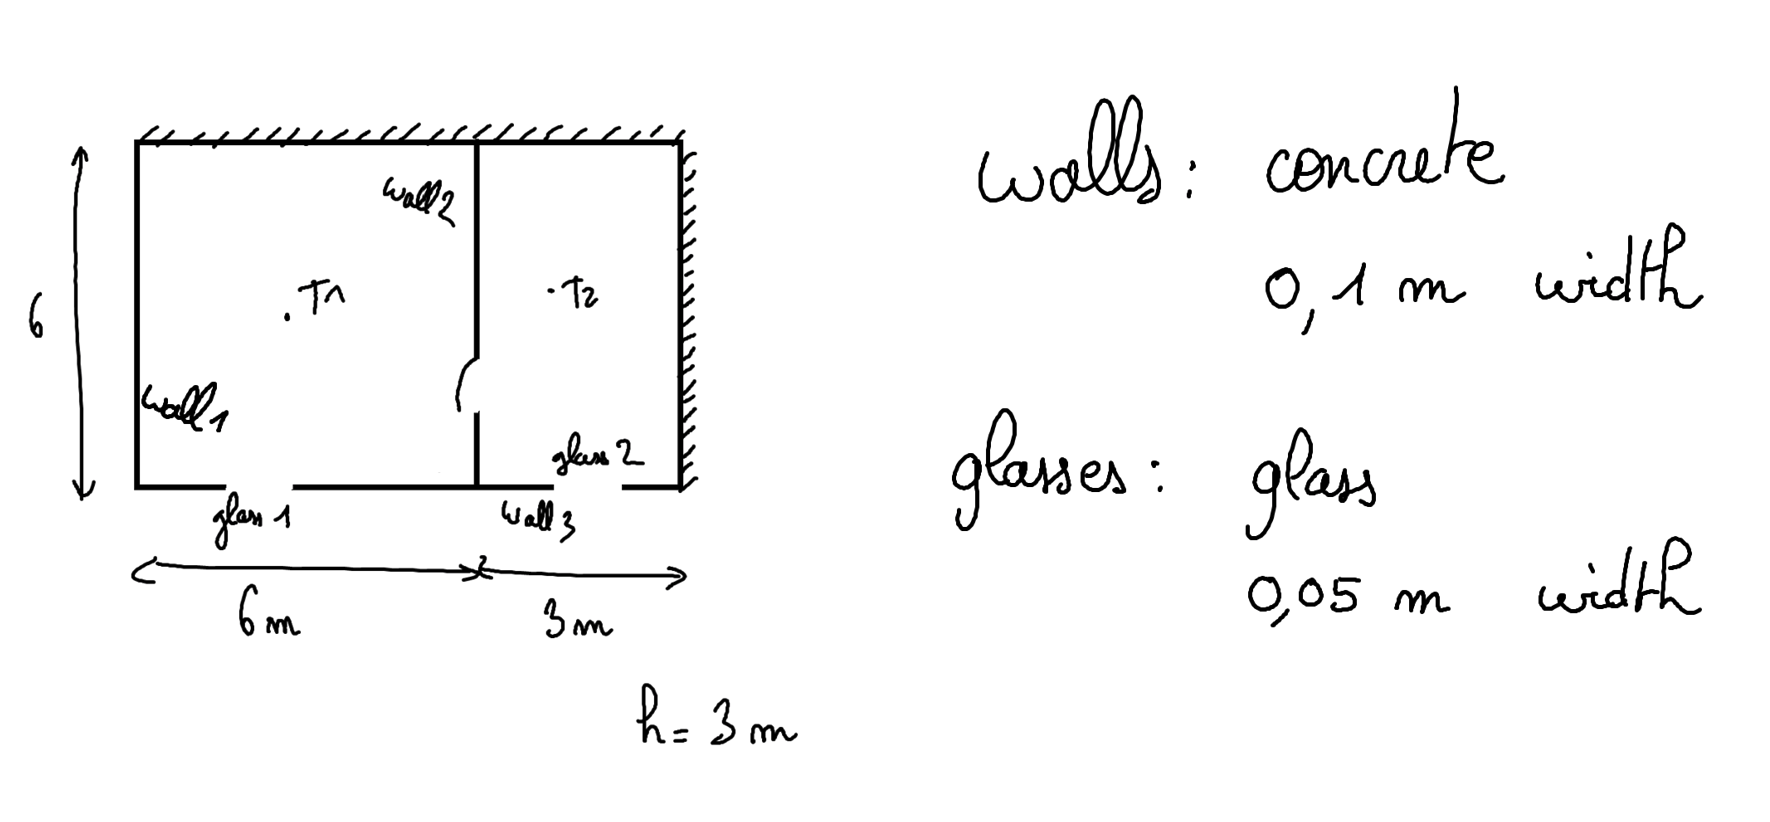

In [44]:
H = 3 #height of the room
L_1 = 12
L_2 = 6 
L_3 = 3 
L_g = 1 

L_door = 1
H_door = 2

S_glass = L_g**2
S_door = L_door * H_door
S_wall1 = L_1*H
S_wall2 = L_2*H
S_wall3 = L_3*H

print(S_wall1, S_wall2, S_wall3)

36 18 9


**Thermal Network Representation**
----------------------------------

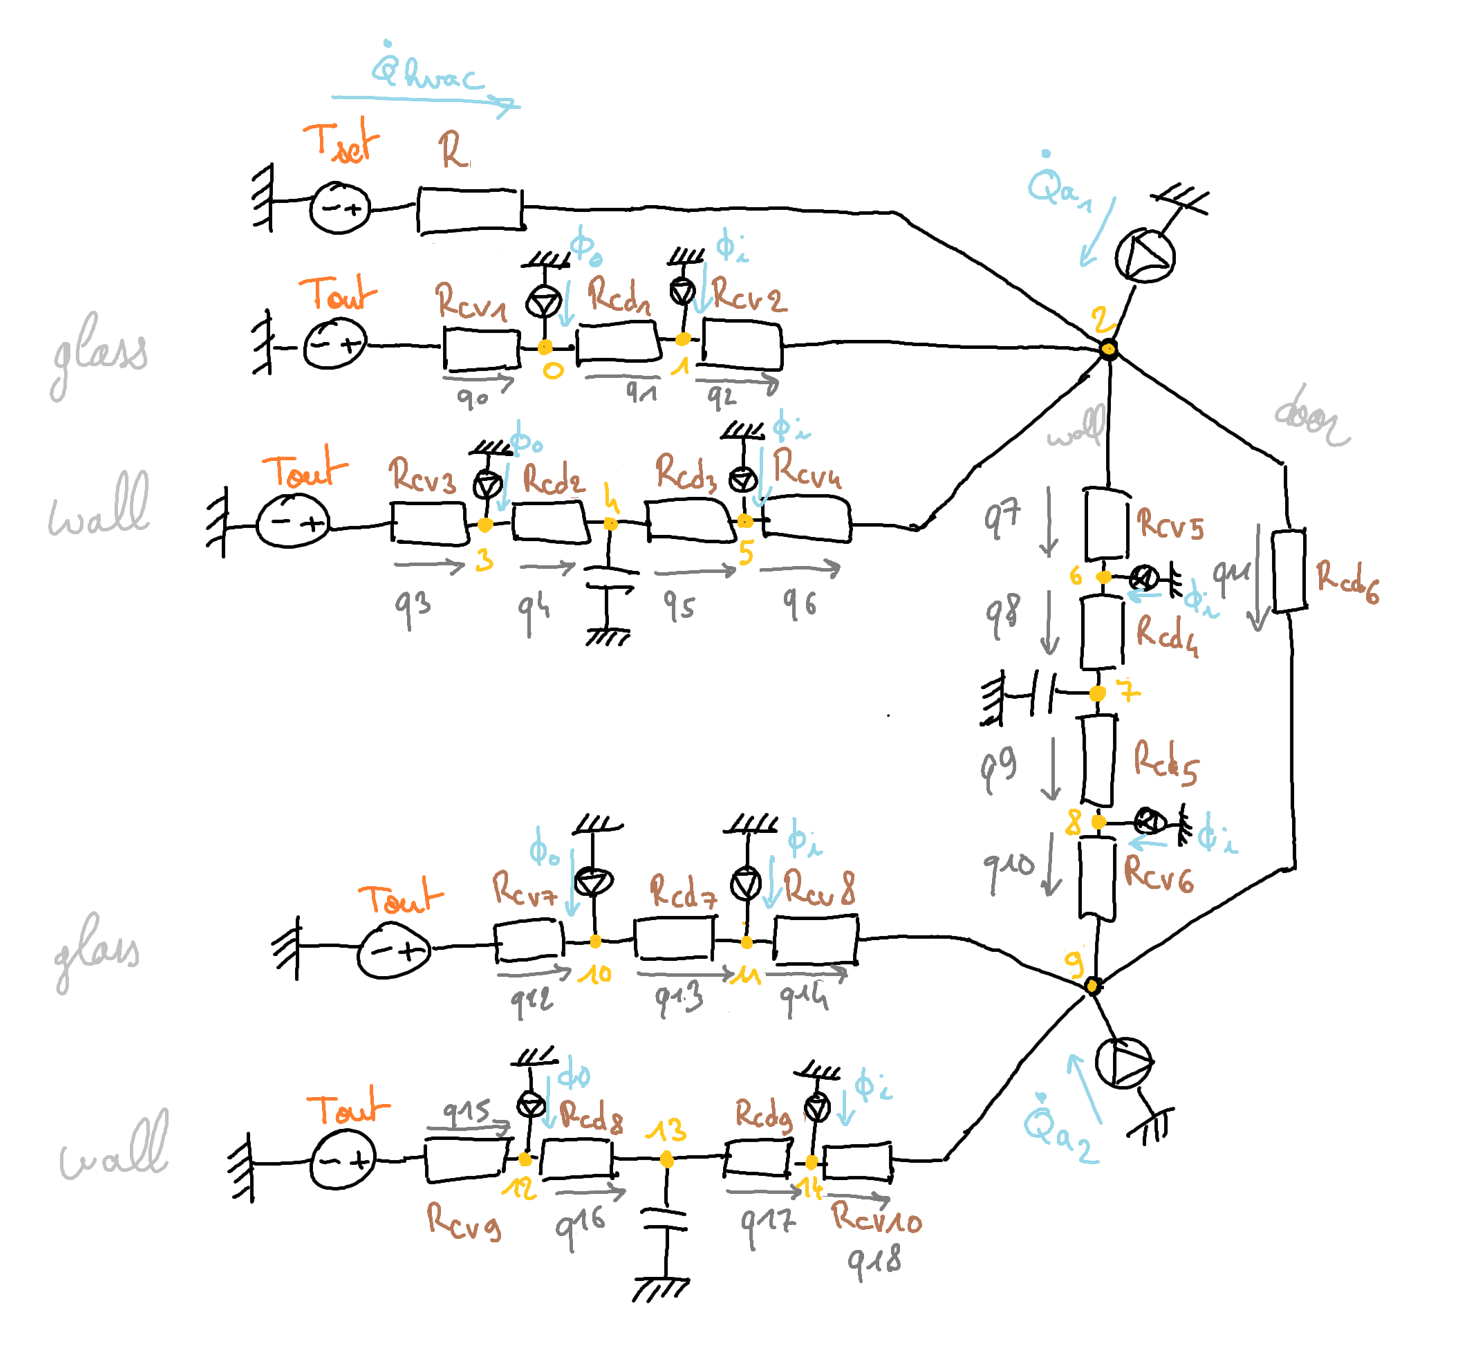

In the thermal network model, we had to take into account the flux coming from de ventilation , Qhvac and the flux from internal sources such as people in the room. 
For the ventilation, the temperature is fixed.
For the glasses, there are 2 convection resistance and 1 conduction resistance. The solar radiation flux for the interior and the exterior is also represented in the model.
For the walls, there are 2 convection resistance and we have decided to have 2 conduction resistance and a capacity which represent the wall width.
We add a conduction resistance for the door connecting the 2 rooms.

**Hypothesis (location, boundary conditions, schedule for usage)**
--------------------------------------------------------------------------

- Two walls are taken as adiabatic.
- We take into account lamps and electric devices radiations.
- We take into account heat power from people and devices inside the building. 


**Thermal properties of the model**
-----------------------------------

In [45]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


In [46]:
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.1}


glass = {'Conductivity': 1,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.05}

wood = {'Conductivity': 0.17,
         'Density': 500,
         'Specific heat': 2500,
         'Width': 0.07}

wall = pd.DataFrame.from_dict({'Wall': concrete,
                               'Glass': glass},
                              orient='index')
wall

,Conductivity,Density,Specific heat,Width
Wall,1.4,2300.0,880,0.10
Glass,1.0,2500.0,1210,0.05


Radiative properties
--------------------

In [47]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print(f'σ = {σ} W/(m²⋅K⁴)')

σ = 5.67e-08 W/(m²⋅K⁴)


Convection coefficients
-----------------------

In [48]:
convection_coeff = {'h_in': 4,
                    'h_out': 10}


Conductances for conduction
---------------------------

In [49]:
G_cd1 = (glass['Conductivity']*S_glass)/glass['Width']

G_cd2 = G_cd3 = ((concrete['Conductivity']*S_wall1)/concrete['Width'])*0.5
G_cd4 = G_cd5 = ((concrete['Conductivity']*S_wall2)/concrete['Width'])*0.5

G_cd6 = ((wood['Conductivity']*S_door)/wood['Width'])

G_cd9 = G_cd8 = ((concrete['Conductivity']*S_wall3)/concrete['Width'])*0.5

G_cd7 = (glass['Conductivity']*S_glass)/glass['Width']

Conductances for convection
---------------------------

In [50]:
G_cv1 = S_glass * convection_coeff['h_out']
G_cv2 = S_glass * convection_coeff['h_in']

G_cv3 = S_wall1 * convection_coeff['h_out']
G_cv4 = S_wall1 * convection_coeff['h_in']

G_cv5 = G_cv6 = S_wall2 * convection_coeff['h_in']

G_cv7 = S_glass * convection_coeff['h_out']
G_cv8 = S_glass * convection_coeff['h_in']

G_cv9 = S_wall3 * convection_coeff['h_out']
G_cv10 = S_wall3 * convection_coeff['h_in']

Conductances for Advection
--------------------------

In [51]:
Va_1 = (L_2**2) * H  #volume of air in room 1 
Va_2 = L_2 * L_3 * H #volume of air in room 2 
ACH = 1 # 1 volume changed per hour

G_adv1 = air['Specific heat'] * air['Density'] * ((ACH * Va_1)/3600)
G_adv2 = air['Specific heat'] * air['Density'] * ((ACH * Va_2)/3600)

Wall Capacities
---------------

In [52]:
C_wall1 = S_wall1 * concrete['Density'] * concrete['Width'] * concrete['Specific heat']
C_wall2 = S_wall2 * concrete['Density'] * concrete['Width'] * concrete['Specific heat']
C_wall3 = S_wall3 * concrete['Density'] * concrete['Width'] * concrete['Specific heat']

**Système d’équations différentielles algébriques (DAE)**
---------------------------------------------------------
After having chosen the model and is thermal representation, we put it in the shape of a equations system :

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ - heat flow vector of size $n_q$ equal to the number of branches;
- $A$ - [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.

- $G$ - conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ - capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ - temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ - heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

Index Matrix A

In [53]:
N_nodes = 15
N_flows = 20

A = np.zeros([N_flows,N_nodes])

A[0,0] = A[1,1] = A[2,2] = A[3,3] = A[4,4] = A[5,5] = A[7,6] = A[8,7] = A[9,8] = A[10,9] = A[11,9] = A[12,10] = A[13,11] = A[15,12] = A[16,13] = A[17,14] = A[6,2] = A[19,2] = A[14,9] = A[18,9] = 1
A[1,0] = A[2,1] =  A[4,3] = A[5,4] = A[6,5] = A[7,2] = A[8,6] = A[9,7] = A[10,8] = A[11,2] = A[13,10] = A[14,11] = A[16,12] = A[17,13] = A[18,14] = -1
print (A)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  

Conductance Matrix G

In [54]:
G = np.zeros([N_flows,N_flows])
Kp = 10**6 #supposed infinite for the moment
G[0,0] = G_cv1
G[1,1] = G_cd1
G[2,2] = G_cv2
G[3,3] = G_cv3
G[4,4] = G_cd2
G[5,5] = G_cd3
G[6,6] = G_cv4
G[7,7] = G_cv5
G[8,8] = G_cd4
G[9,9] = G_cd5
G[10,10] = G_cv6
G[11,11] = G_cd6
G[12,12] = G_cv7
G[13,13] = G_cd7
G[14,14] = G_cv8
G[15,15] = G_cv9
G[16,16] = G_cd8
G[17,17] = G_cd9
G[18,18] = G_cv10
G[19,19] = G_0 = Kp

print(G)

[[1.00000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.00000000e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.60000000e+02
  0.0

Capacity Matrix C

In [55]:
C = np.zeros([N_nodes, N_nodes])

C[4,4] = C_wall1
C[7,7] = C_wall2
C[13,13] = C_wall3
print(C)

[[      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0. 7286400.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.       0.       0.       0.       0.]
 [      0.       0. 

Flow matrix f

In [56]:
phi_out , phi_in= 10**(-6) , 10**(-6) #No internal sources of light and we are at night (this value is only taken to have a non null value for simulatio)
Q_a1 = Q_a2 = 10**(-6) #1 person in each room
Q_hvac = 10**(-6) #α_wSW * 1000 * (S_wall3+S_wall1+S_wall2) --> for the moment we keep it null for steady state tests
f = np.zeros(N_nodes)
f[0] = f[3] = f[10] = f[12] = phi_out
f[1] = f[5] = f[6] = f[8] = f[11] = f[14] = phi_in
f[2] = Q_a1 + Q_hvac
f[9] = Q_a2
print(f)

[1.e-06 1.e-06 2.e-06 1.e-06 0.e+00 1.e-06 1.e-06 0.e+00 1.e-06 1.e-06
 1.e-06 1.e-06 1.e-06 0.e+00 1.e-06]


Temperature source vector b 

In [57]:
b = np.zeros(N_flows)
T_out = 4
T_sp = 19

b[[0, 3, 12, 15]] = T_out
b[19] = T_sp

Output vector y

In [58]:
y = np.zeros(N_nodes)         # nodes
y[[2, 9]] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


**Steady State Solution**
-------------------------

In [59]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

"""b[[0, 3, 12, 15]] = 1
θ_steady_To = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
np.set_printoptions(precision=3)
print('When To = 1°C, the temperatures in steady-state are:', θ_steady_To, '°C')

print(f'The indoor temperature is: {θ_steady_To[-1]:.3f} °C')
"""
print()

θ = [ 7.74973938  9.62460902 18.99895696  6.35938649  9.72993862 13.10049075
 17.20947235 16.1869097  15.16434706 13.37486242  6.34371574  7.51557356
  5.47469747  7.58140813  9.68811879] °C



**State space representation**
==============================

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\
y = C_s \theta_s + D_s u
\end{array}\right.$$

- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;


- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure, $b_T$, and heat flows, $f_Q$) of the thermal network, where:


    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponds to branches 0, 8, 10 and 11;
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponds to nodes 0, 4, 6, and 7;
   
- $y$ - vector of outputs, a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = \theta_6$, the indoor temperature.


- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;


- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;


- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;


- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

In [60]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-3.29193102e-05  6.12922819e-10  1.83901432e-11]
 [ 1.22584564e-09 -1.75785547e-05  3.78677262e-06]
 [ 7.35605726e-11  7.57354524e-06 -2.91337082e-05]] 

Bs = 
 [[3.14363485e-11 2.03441060e-05 2.00686086e-12 0.00000000e+00
  1.25745394e-05 3.14363485e-12 4.71545228e-12 1.25745394e-11
  5.65114056e-08 8.73403812e-08 4.57255978e-12 2.91907034e-13
  8.02744344e-13 2.00686086e-13 3.01029129e-13 0.00000000e+00
  2.91907034e-13]
 [3.34432094e-11 0.00000000e+00 4.13239076e-07 0.00000000e+00
  1.33772838e-05 3.34432094e-12 5.01648141e-12 1.33772838e-11
  0.00000000e+00 4.86446682e-12 1.74676482e-07 2.34779119e-07
  1.65295630e-07 4.13239076e-08 6.19858613e-08 0.00000000e+00
  6.01075019e-08]
 [2.00686086e-12 0.00000000e+00 4.13237069e-07 2.03441060e-05
  8.02744344e-07 2.00686086e-13 3.01029129e-13 8.02744344e-13
  0.00000000e+00 2.91907034e-13 2.91907034e-13 6.01072100e-08
  1.65294827e-07 4.13237069e-08 6.19855603e-08 2.26045622e-07
  4.09450445e-07]] 

Cs = 
 [[9.16231239e-05 4.873

Input vector u
--------------

For the input vector, we have : $$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$
- $b_T$ is a vector of the nonzero elements of vector $b$ of temperature sources
- $f_Q$ - vector the nonzero elements of vector $f$ of flow sources



In [61]:
bT = np.array([T_out, T_out, T_out, T_out, T_sp])    
fQ = np.array([f[0], f[1], f[2], f[3], f[5], f[6], f[8], f[9], f[10], f[11], f[12], f[14]])        # [Φo, Φi, Qa, Φa]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [4.0e+00 4.0e+00 4.0e+00 4.0e+00 1.9e+01 1.0e-06 1.0e-06 2.0e-06 1.0e-06
 1.0e-06 1.0e-06 1.0e-06 1.0e-06 1.0e-06 1.0e-06 1.0e-06 1.0e-06]



**Steady-State value of the output of the state space representation**
------------------------------------------------------------------

After computing the matrix As, Bs, Cs, Ds and the input vector we can now compute the steady state value of the output of the state space representation : 

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [62]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [18.99895696 13.37486242] °C


**Dynamic Simulation**
==================

Time Step 
----

The condition of stability for Euler explicit integration we have : 
$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$


In order to find the time step, we have decided to use this condition : 

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$


with $T_i = - \frac{1}{\lambda_i} $

In [63]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [30377.30717083 64606.43479053 32016.46565827] s 

2 x Time constants: 
 [ 60754.61434166 129212.86958106  64032.93131654] s 

Maximum time step: 60754.61 s = 1012.58 min


Our dt_max is relatively big yet not wrong. Indeed, this shows that we have considered big resistances ( as T = RC ) and neglected small capacities compared to others (such as glass). We can thus state that our model is more suited for long term building simulation, and not for instantaneous regulation of temperature. 

In [64]:
# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 60720.0 s = 1012 min


**Settling Time**
-----------------

We can also calculate the settling time which is 4 times the larger time constant.

**Step Response**
=================

**Input vector for dynamic simulation**
---------------------------------------

The input vector for the dynamic simulation is based from the first input vector but now, we take the time step into account. We will have n value for the outdoor temperature at discrete time. 

**Time integration**
--------------------

Two methods can be used to integrate the state space model :

Euler explicit :  
$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$


Euler implicit :

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$


where $k = 0, ... , n - 1$,

**Simulation with weather data**
================================

**Start End Time**
------------------

**Inputs**
----------

Dynamic simulation needs time series of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on Weather data and solar radiation

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar direct normal irradiance (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or diffuse sky radiation) , W/m²;

from the start to the end date.

**Solar irradiance on the walls**
---------------------------------

We have 3 different irradiance on the walls : 
- direct irradiance, W/m2
- diffuse irradiance, W/m2
- reflected irradiance, W/m2


The total solar irradiance $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

**Resample weather data**
-------------------------

In order to do the calculations, we need to resemble the time step. It will be used for numerical integration. 


**Input vector in time**
------------------------

The input is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

where:


$T_o$: the time series vector of outdoor temperatures (from weather data), °C.


$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.


$\Phi_o$: time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall:


$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$


where:
- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².


$\Phi_i$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall:


$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$


where:

- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².


$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.


$\Phi_a$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the window glass:


$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$


where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².


**Initial condition**
---------------------